In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import random
import warnings
warnings.filterwarnings("ignore")

## Baseline

In [22]:
train = pd.read_csv('./data/train/train.csv')

In [23]:
submission = pd.read_csv('./data/sample_submission.csv')

In [24]:
# data를 넣어주면 
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']] # day, minute, 

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')   # 뒤에서 48개의 값을 지우고 가장 마지막 값으로 채운다
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill') # 뒤에서 96개의 값을 지우고 가장 마지막 값으로 채운다
        temp = temp.dropna()  # 결측치 제거
        
        return temp.iloc[:-96] # 아 이건 예측값이 0이 되버리니까 제거해버리는구나 ㅇㅋㅇㅋ

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]
df_train = preprocess_data(train)

# RH(상대 습도)

In [25]:
def RH_2(df_train):
    df_train['new_RH']=0
    # RH가 ~20 사이, 20~40 사이, 40~60, 60~80, ~100
    df_train.loc[df_train['RH']<30,'new_RH'] = 0
    df_train.loc[(30<=df_train['RH']) & (df_train['RH']<60),'new_RH'] = 1
    df_train.loc[60<=df_train['RH'],'new_RH'] = 2
    return df_train

# WS(풍속)

In [26]:
def WS_3(df_train):
    df_train['new_WS']=0
    df_train.loc[df_train['WS']<1.5,'new_RH'] = 0
    df_train.loc[(1.5<=df_train['WS']) & (df_train['WS']<4),'new_WS'] = 1
    df_train.loc[(4<=df_train['WS']) & (df_train['WS']<6),'new_WS'] = 2
    df_train.loc[6<=df_train['WS'],'new_WS'] = 3
    return df_train

# DNI, DHI를 계산해서 GHI 계산

In [27]:
def cal_ghi(df):
    df['GHI']=0
    lst = list(df.columns)
    idx_hour = lst.index('Hour')
    idx_dhi = lst.index('DHI')
    idx_dni = lst.index('DNI')
    idx_ghi = lst.index('GHI')
    for i in range(len(df)):
        hour = df.iloc[i,idx_hour]
        if 8 <= hour <= 16:
            degree = (hour-7) * np.pi/18
            GHI = df.iloc[i,idx_dni] + df.iloc[i,idx_dhi]*(np.cos(90-degree))  # DHI +DNI*cos(Θ)
            if GHI<0:
                GHI=0
            df.iloc[i,idx_ghi] = GHI
    return df

# Temperature

In [28]:
def max_temp(df):
    a = []
    for i in range(0,len(df),48):
        temp = df[i:i+48]
        max_val = temp['T'].max()
        temp['max'] = max_val
        a.append(temp)
    dfdf = pd.concat(a)
    return dfdf
def ratio_temp(df):
    df = max_temp(df)
    max_val = df['T'].max()
    df['ratio_temp'] =  df['max']/max_val
    return df

# Hour 처리
- 12시 기준으로 멀어질수록 값이 작아지게? 커지게?

In [29]:
def gap_abs(df):
    df['new_hour'] = (df['Hour'] - 12).abs() - 12
    return df

# 100 -  RH*Max_temp

In [30]:
def idk(df):
    df['idk'] = 100 - df['RH']*df['max']
    return df

# GHI

In [31]:
df_train = cal_ghi(df_train)
df_train = RH_2(df_train)
df_train = WS_3(df_train)
df_train = ratio_temp(df_train)
df_train = gap_abs(df_train)
df_train = idk(df_train)

In [32]:
# ['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'Target1', 'Target2','temper_group', 'new_hour', 'GHI', 'new_RH', 'new_WS', 'max', 'ratio_temp']
df_train.columns

Index(['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'Target1', 'Target2',
       'GHI', 'new_RH', 'new_WS', 'max', 'ratio_temp', 'new_hour', 'idk'],
      dtype='object')

In [33]:
drop_list = ['Hour']

In [34]:
df_train = df_train.drop(drop_list,axis=1)

In [35]:
# df_train.columns['DHI', 'DNI','new_RH','new_WS', 'T', 'ratio_temp', 'GHI', 'new_hour','TARGET', 'Target1', 'Target2']

In [36]:
df_train.columns

Index(['TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'Target1', 'Target2', 'GHI',
       'new_RH', 'new_WS', 'max', 'ratio_temp', 'new_hour', 'idk'],
      dtype='object')

In [37]:
df_train= df_train[['TARGET', 'DHI', 'DNI', 'T', 'GHI', 'new_RH', 'new_WS', 'max', 'ratio_temp', 'new_hour', 'idk', 'Target1', 'Target2']]

In [38]:
df_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [39]:
X_test = cal_ghi(X_test)
X_test = RH_2(X_test)
X_test = WS_3(X_test)
X_test = ratio_temp(X_test)
X_test = gap_abs(X_test)
X_test = idk(X_test)

In [40]:
X_test = X_test[['TARGET', 'DHI', 'DNI', 'T', 'GHI', 'new_RH', 'new_WS', 'max', 'ratio_temp', 'new_hour', 'idk']]

In [41]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

In [42]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [43]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [44]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [45]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.38573
Early stopping, best iteration is:
[435]	valid_0's quantile: 1.38393
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.19236
[1000]	valid_0's quantile: 2.17569
Early stopping, best iteration is:
[997]	valid_0's quantile: 2.17551
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.58336
[1000]	valid_0's quantile: 2.56327
[1500]	valid_0's quantile: 2.55156
Early stopping, best iteration is:
[1401]	valid_0's quantile: 2.55099
0.4
[LightGBM] [Warning] bagging_fra

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [46]:
# Target2
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.39653
[1000]	valid_0's quantile: 1.39836
Early stopping, best iteration is:
[773]	valid_0's quantile: 1.39358
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.20903
Early stopping, best iteration is:
[417]	valid_0's quantile: 2.20316
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.59435
[1000]	valid_0's quantile: 2.56695
[1500]	valid_0's quantile: 2.55589
[2000]	valid_0's quantile: 2.54466
[2500]	valid_0's quantile: 2.54032
[3000]	valid_0's quantile: 2.53607
E

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [47]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [48]:
submission.to_csv('./data/number_16.csv', index=False)

In [40]:
y = models_1[3].feature_importances_
label = models_1[3].feature_name_

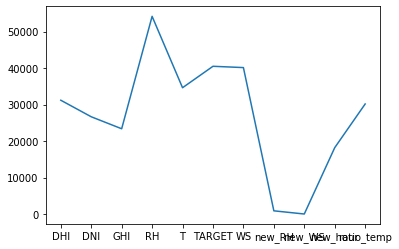

In [41]:
# drop 전
y = models_1[3].feature_importances_
label = models_1[3].feature_name_
sns.lineplot(x = label, y = y)

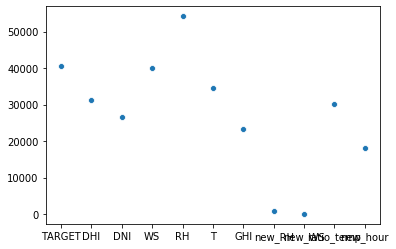

In [42]:
# WS RH drop
y = models_1[3].feature_importances_
label = models_1[3].feature_name_
sns.scatterplot(x = label, y = y)

In [43]:
# weather, new_RH, temper_group drop
label

['TARGET',
 'DHI',
 'DNI',
 'WS',
 'RH',
 'T',
 'GHI',
 'new_RH',
 'new_WS',
 'ratio_temp',
 'new_hour']

In [36]:
num_13 = ['DHI', 'DNI', 'T', 'new_hour', 'GHI', 'new_RH','new_WS', 'ratio_temp', 'TARGET']
num_14 = ['TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'GHI', 'ratio_temp', 'new_hour']

In [38]:
print(set(num_13))
print(set(num_14))

{'GHI', 'new_RH', 'new_WS', 'DHI', 'new_hour', 'DNI', 'T', 'TARGET', 'ratio_temp'}
{'GHI', 'RH', 'WS', 'DHI', 'DNI', 'new_hour', 'T', 'TARGET', 'ratio_temp'}


In [47]:
X_test.columns

Index(['TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'GHI', 'new_RH', 'new_WS',
       'ratio_temp', 'new_hour'],
      dtype='object')